In [1]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path


from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [2]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)

### Classifier

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        

    def forward(self, x):
        print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    

def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    opt.zero_grad()
    pred = cl(x)
    pred.to(device)
    print(pred.shape, y.shape)

    err = F.nll_loss(F.log_softmax(pred, dim=0), y)
    #     L1 regularizer
#     with torch.enable_grad():
#         reg = 1e-05
#         l1_loss = torch.zeros(1)
#         for name, param in cl.named_parameters():
#             if 'bias' not in name:  # param is a weight tensor
#                 l1_loss += reg*torch.sum(torch.abs(param))
#     err += l1_loss.item()
    err.backward()
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

### Training

In [6]:
num_epochs = 4
e_losses = [] 

# Load pre-trained model
cl = Classifier().to(device)

# optimizer
decay = 0
cl_opt = optim.Adam(cl.parameters(), lr=0.001, weight_decay=decay)
criterion = nn.CrossEntropyLoss()

for e in range(num_epochs):
    cl.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        target = np.argmax(target, axis=1)  # transform from one-hot to int
        c_error,c_pred = train_classifier(cl,cl_opt, data.to(device), target.to(device))
        e_losses.append(c_error.cpu().data.numpy())
        break
    break
    acc = test_model(cl,test_dataloader)
    print("Epoch ", e, ": Test accuracy: ", 100*acc, "%")

print("Performance in the trained model: ")
acc_test = test_model(cl,test_dataloader)
print("Test accuracy: ", 100*acc_test, "%")
print("FINISHED!!!")

torch.Size([64, 1, 28, 28])
torch.Size([64, 10]) torch.Size([64])
Performance in the trained model: 
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
Test accuracy:  11.12 %
FINISHED!!!


In [11]:
torch.save(cl.state_dict(), 
           '../saved_models/Carlini/L1/l1_regularized_1e-05_model_03.pth')

### Create ART classifier

In [16]:
# Create ART classifier with the TRAINED model
classifier = PyTorchClassifier(
    model=cl,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=cl_opt,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

In [17]:
# Should yield the same accuracy as the one printed above
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

Accuracy on benign test examples: 98.79 %


## Carlini

In [18]:
def CarliniL2(classifier, x_test, init_const):
    start = time.time()
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)
    end = time.time()
    print(round((end-start)/60, 3), "mins")
    
    return x_test_adv


def CarliniLInf(classifier, x_test, epsilon):
    start = time.time()
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    end = time.time()
    print(round((end-start)/60, 3), "mins")
    
    return x_test_adv


# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    for test, adv_test in zip(x_test, x_test_adv):
        dist += np.linalg.norm(test-adv_test)
    dist /= len(x_test)
    return dist

In [21]:
# CARLINI LINF
x_test_adv = CarliniLInf(classifier, x_test[:1000], epsilon=0.01)


(10000, 1, 28, 28)


KeyboardInterrupt: 

In [22]:
print(x_test.shape)
print(x_test_adv.shape)

(10000, 1, 28, 28)
(1000, 1, 28, 28)


In [310]:
# CARLINI L2

constants = [0.1, 10]
# BE CAREFULL adversarial_samples = dict()
# adversarial_dist = dict()
for init in constants:
    x_test_adv = CarliniL2(classifier, x_test, init_const=init)
    adversarial_samples[init] = x_test_adv
    adversarial_dist[init] = L2distance(x_test, x_test_adv)

5.939 mins
6.319 mins


In [385]:
# MEASURE ADVERSARIAL ACCURACY
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:1000], axis=1)) / 1000# len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

Accuracy on benign test examples: 98.8 %


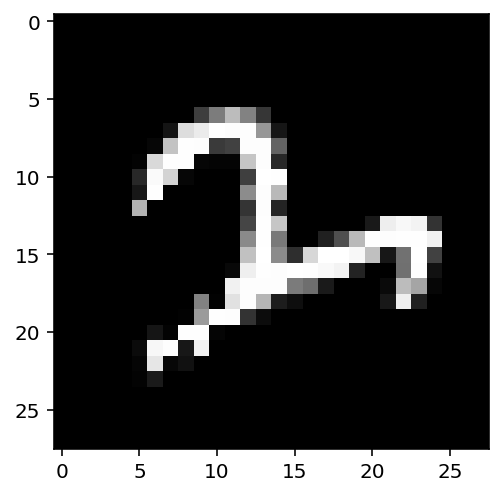

In [381]:
image = x_test_adv[6].squeeze()
# image = x_test[4].squeeze()
plt.imshow(image, cmap="gray")

## adversarial_dist

In [315]:
# TEST
res = dict()
for init, x_test_adv in adversarial_samples.items():
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    res[init] = accuracy*100
    print("init_const: {} - Accuracy on adversarial test examples: {}%".format(init, accuracy * 100))

init_const: 1.0 - Accuracy on adversarial test examples: 55.84%
init_const: 0.1 - Accuracy on adversarial test examples: 97.97%
init_const: 10 - Accuracy on adversarial test examples: 5.18%


In [327]:
# TEST
res = dict()
for init, x_test_adv in adversarial_test.items():
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    res[init] = accuracy*100
    print("init_const: {} - Accuracy on adversarial test examples: {}%".format(init, accuracy * 100))

init_const: 0.1 - Accuracy on adversarial test examples: 98.71%
init_const: 1.0 - Accuracy on adversarial test examples: 95.02000000000001%
init_const: 10 - Accuracy on adversarial test examples: 88.1%
